In [1]:
import pandas as pd
import janitor as jn
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import ECDF
import arviz as az

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Darwin's Finches

A research group has taken measurements of the descendants of the finches that Charles Darwin observed when he postulated the theory of evolution.

We will be using Bayesian methods to analyze this data, specifically answering the question of how quantitatively different two species of birds' beaks are.

## Data Credits

The Darwin's finches datasets come from the paper, [40 years of evolution. Darwin's finches on Daphne Major Island][data]. 

One row of data has been added for pedagogical purposes.

[data]: (https://datadryad.org/resource/doi:10.5061/dryad.g6g3h). 

Let's get started and load the data.

In [2]:
from data import load_finches_2012
df = load_finches_2012()

**Exercise:** View a random sample of the data to get a feel for the structure of the dataset.

In [3]:
df.sample(5)

,band,species,beak_length,beak_depth,species_enc
68,19889,fortis,10.00,8.40,0
131,19214,scandens,12.95,8.85,1
16,19210,fortis,11.30,9.60,0
237,21286,scandens,12.40,8.40,1
19,19226,fortis,9.70,7.50,0


**Note:** I have added one row of data, simulating the discovery of an "unknown" species of finch for which beak measurements have been taken.

For pedagogical brevity, we will analyze only beak depth during the class. However, I would encourage you to perform a similar analysis for beak length as well.

In [4]:
# These are filters that we can use later on.
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'
unknown_filter = df['species'] == 'unknown'

**Exercise:** Recreate the estimation model for finch beak depths. A few things to note:

- Practice using numpy-like fancy indexing.
- Difference of means & effect size are optional.
- Feel free to play around with other priors.

A visual representation of the model using distribution diagrams is as follows:

![](../images/darwins-finches-model.jpg)

In [5]:
with pm.Model() as beak_depth_model:
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=100, shape=(3,))
    # Define the prior for the observed variance of the beak depths
    sd = pm.HalfCauchy('sd', beta=100, shape=(3,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu,
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_depth'])

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


**Exercise:** Perform MCMC sampling to estimate the posterior distribution of each parameter.

In [6]:
with beak_depth_model:
    trace = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sd, mean]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error

**Exercise:** Diagnose whether the sampling has converged or not using trace plots.

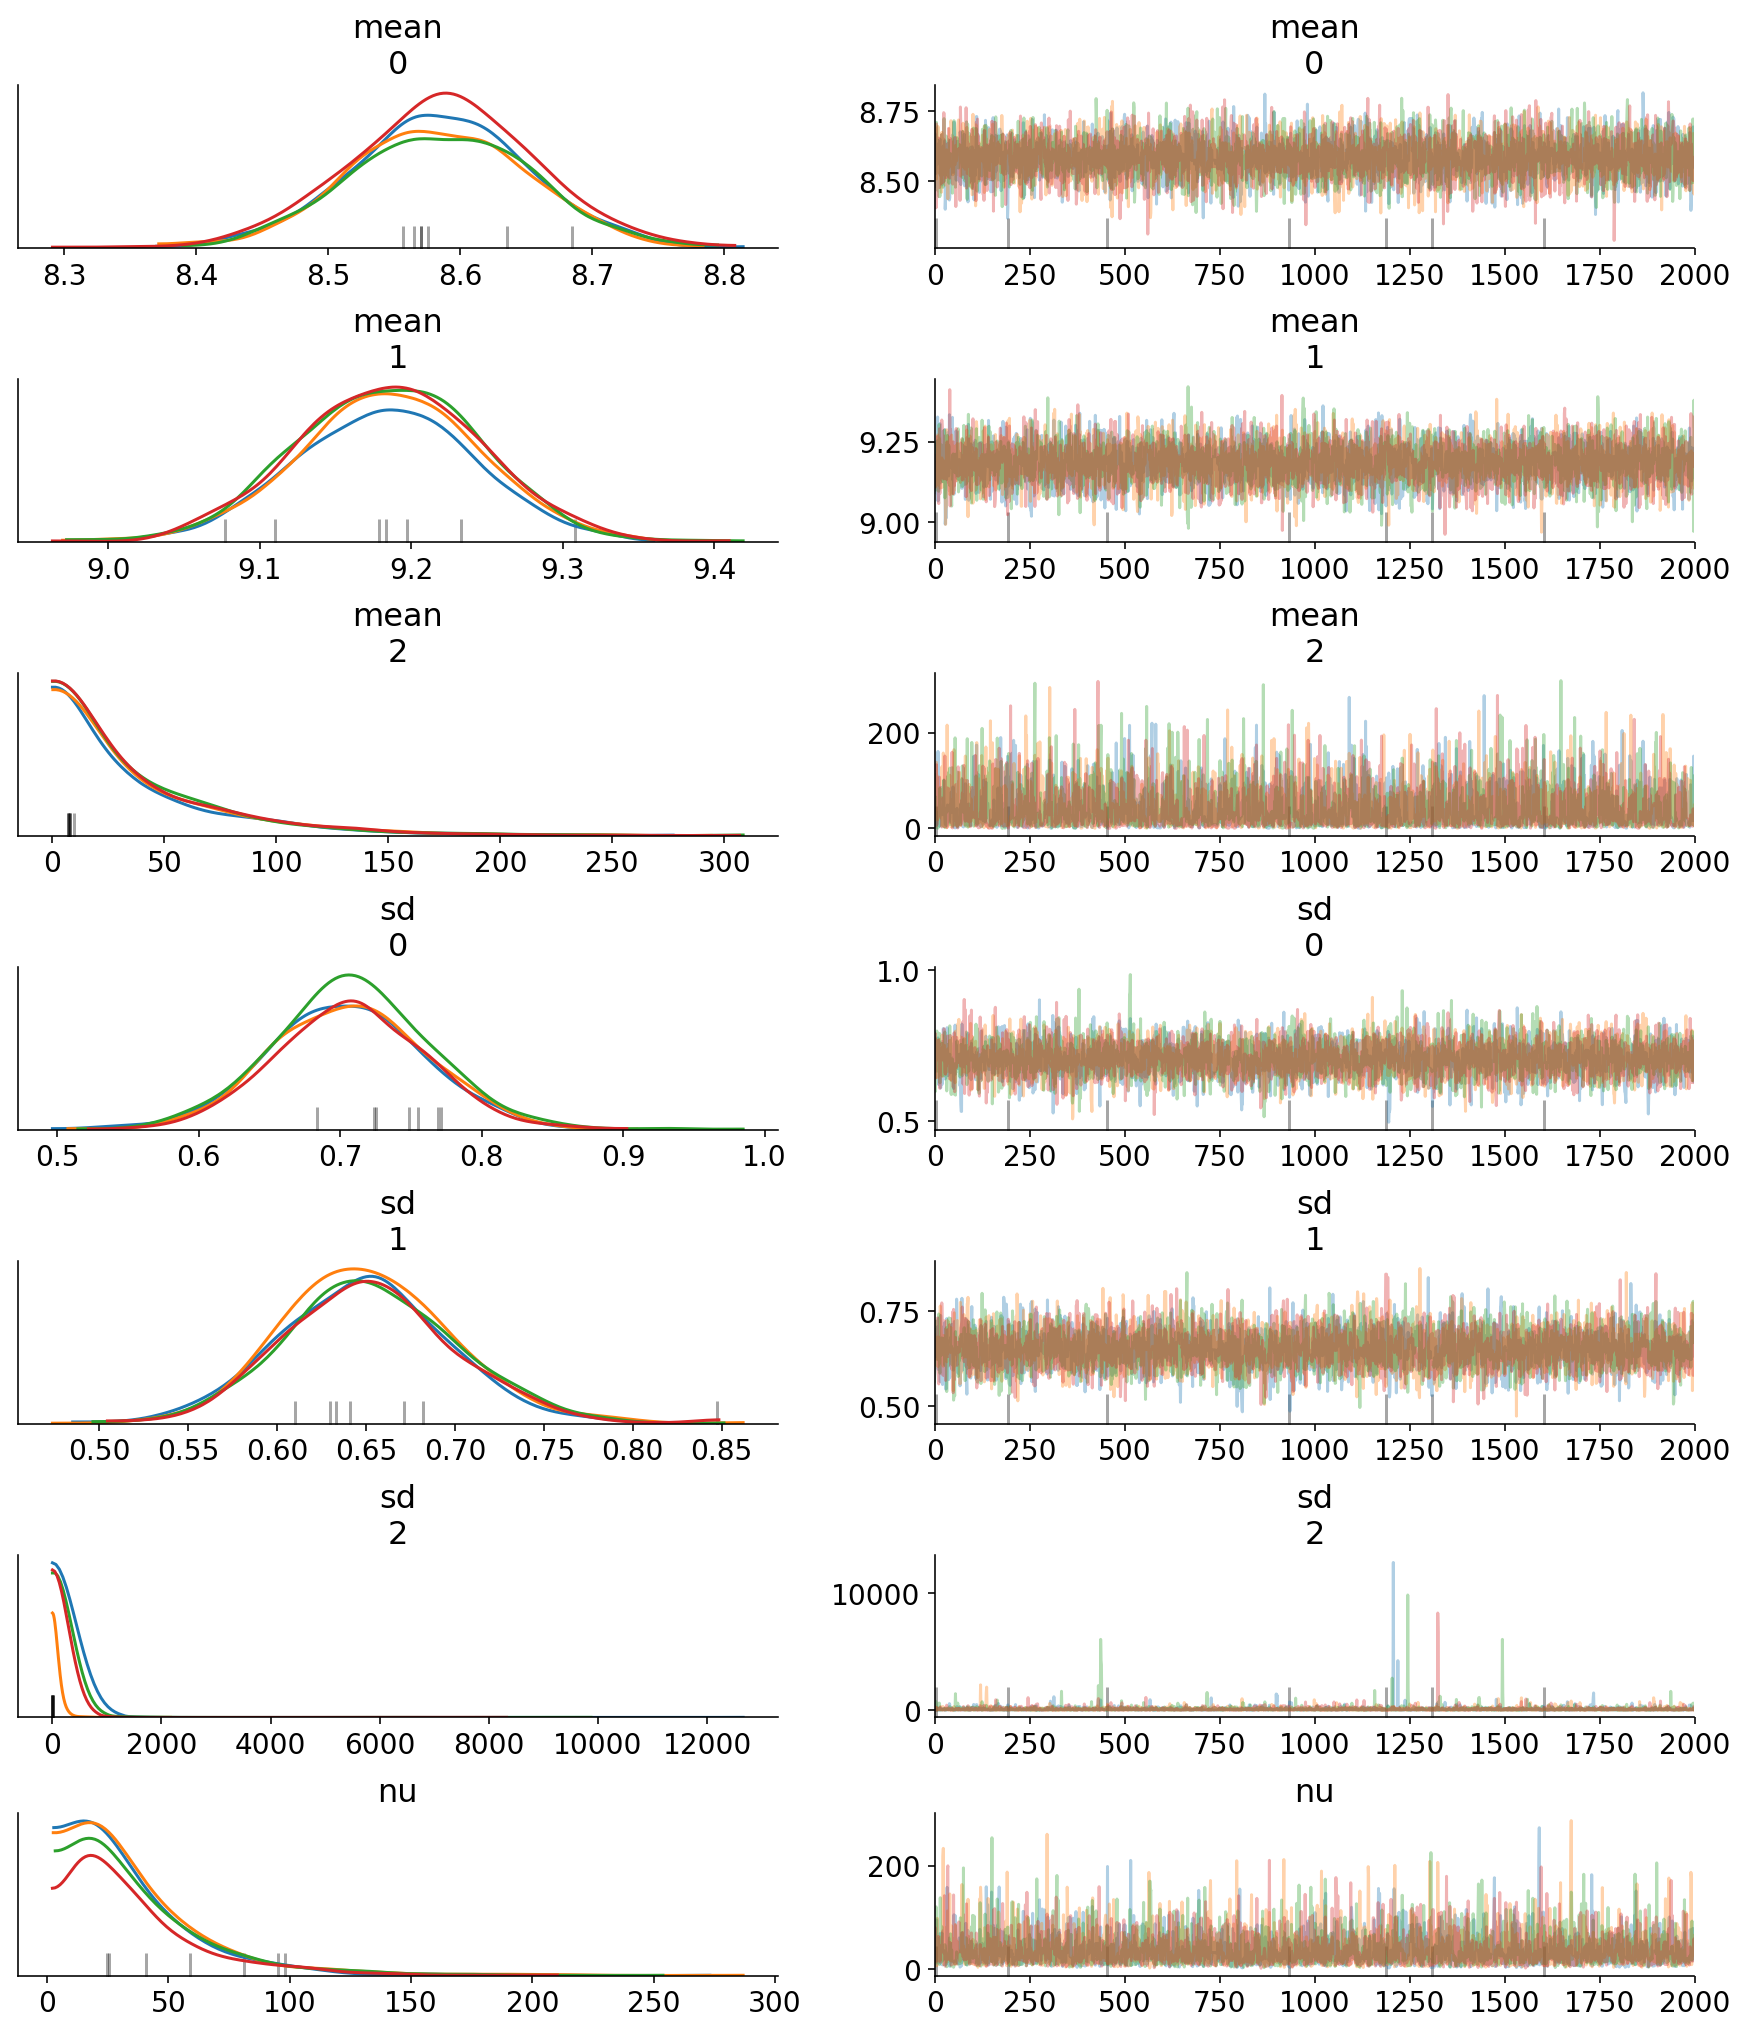

In [12]:
traces = az.plot_trace(trace)

**Exercise:** Visualize the posterior distribution over the parameters using the forest plot.

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(<Figure size 432x374.4 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f71879d5048>],
       dtype=object))

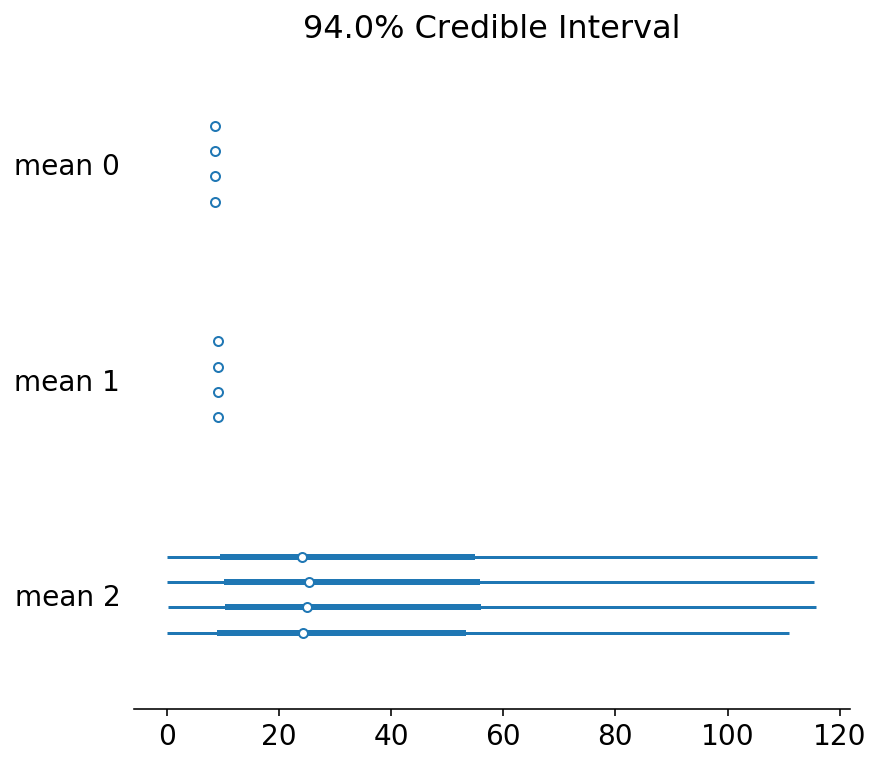

In [13]:
az.plot_forest(trace, var_names=['mean'])

**Exercise:** Visualize the posterior distribution of the means using `plot_posterior`.

Text(0.5, 1.0, 'unknown')

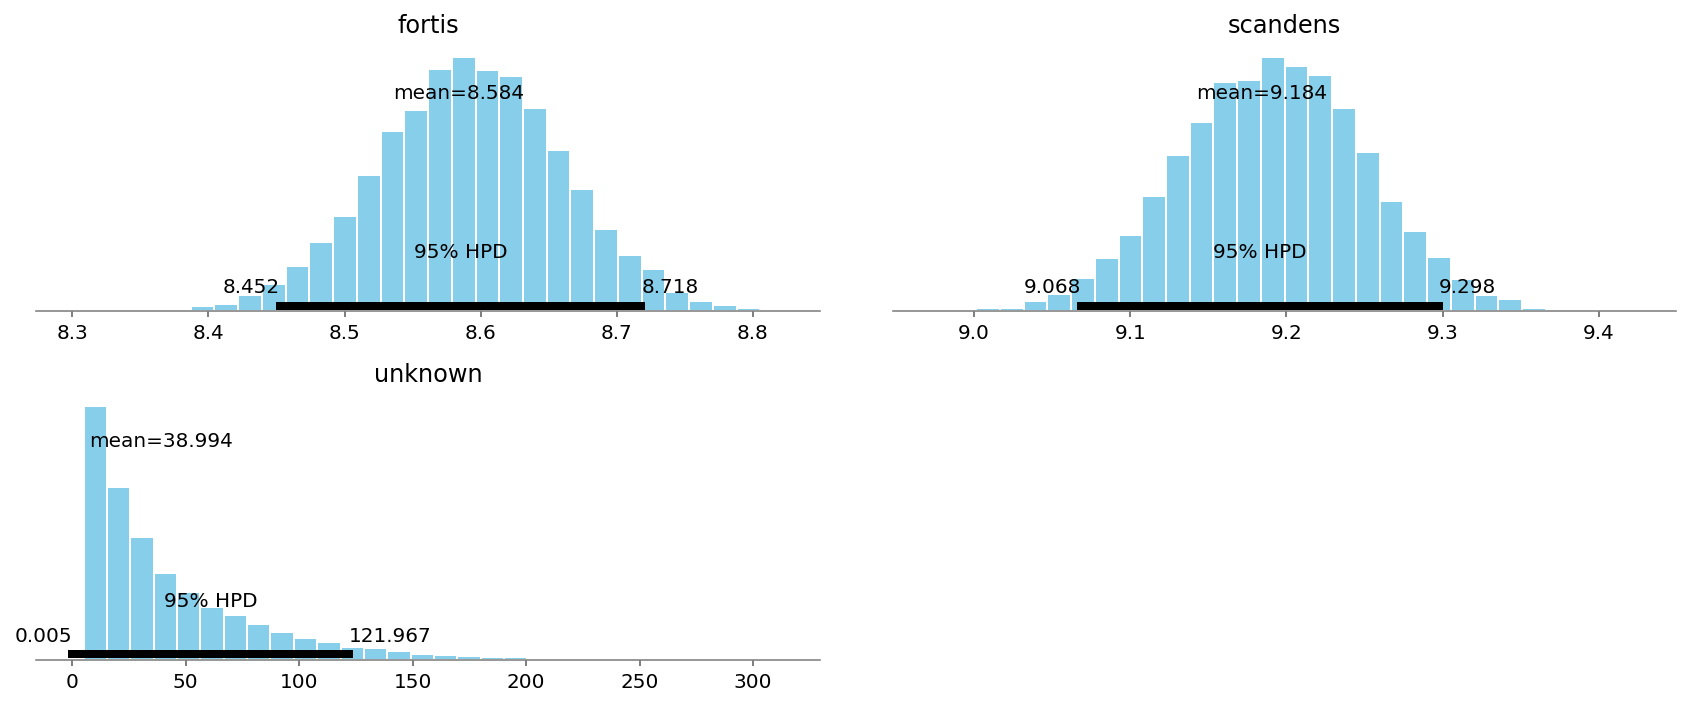

In [14]:
ax1, ax2, ax3 = pm.plot_posterior(trace, varnames=['mean'])
ax1.set_title('fortis')
ax2.set_title('scandens')
ax3.set_title('unknown')

**Discuss:**
- Is the posterior distribution of beaks for the unknown species reasonable?

**Exercise:** Perform a posterior predictive check to visually diagnose whether the model describes the data generating process well or not.

In [15]:
samples = pm.sample_ppc(trace, model=beak_depth_model, samples=2000)

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 2000/2000 [00:01<00:00, 1813.54it/s]


Hint: Each column in the samples (key: "likelihood") corresponds to simulated measurements of each finch in the dataset. We can use fancy indexing along the columns (axis 1) to select out simulated measurements for each category, and then flatten the resultant array to get the full estimated distribution of values for each class.

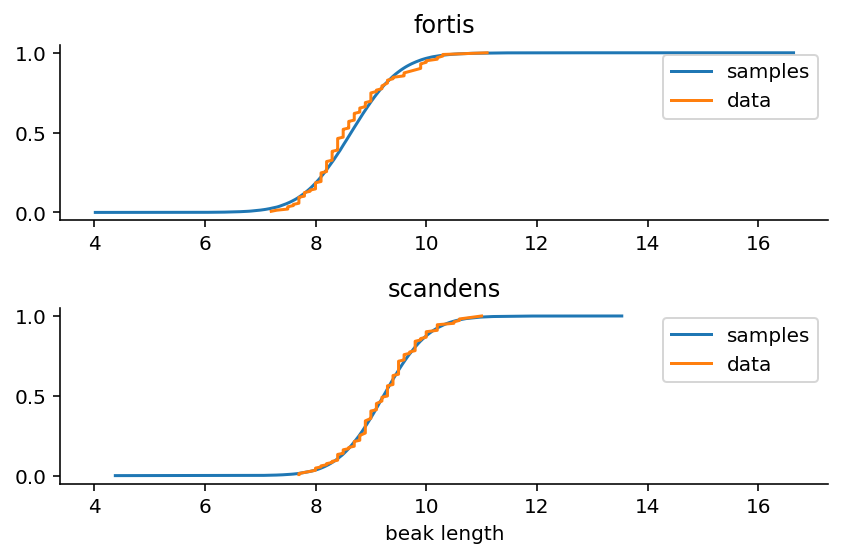

In [16]:
fig = plt.figure()
ax_fortis = fig.add_subplot(2, 1, 1)
ax_scandens = fig.add_subplot(2, 1, 2, sharex=ax_fortis)

# Extract just the fortis samples.
fortis_samples = samples['likelihood'][:, df[fortis_filter].index].flatten()
# Compute the ECDF for the fortis samples.
x_s, y_s = ECDF(fortis_samples)
ax_fortis.plot(x_s, y_s, label='samples')

# Extract just the fortis measurements.
fortis_data = df[fortis_filter]['beak_depth']
# Compute the ECDF for the fortis samples
x, y = ECDF(fortis_data)
ax_fortis.plot(x, y, label='data')

ax_fortis.legend()
ax_fortis.set_title('fortis')

# Extract just the scandens samples.
scandens_samples = samples['likelihood'][:, df[scandens_filter].index].flatten()
# Compute the ECDF for the scandens samples
x_s, y_s = ECDF(scandens_samples)
ax_scandens.plot(x_s, y_s, label='samples')

# Extract just the scandens measurements.
scandens_data = df[scandens_filter]['beak_depth']
# Compute the ECDF for the scanens samples
x, y = ECDF(scandens_data)

ax_scandens.plot(x, y, label='data')
ax_scandens.legend()
ax_scandens.set_title('scandens')
ax_scandens.set_xlabel('beak length')

plt.tight_layout()

## Summary

1. NumPy-like fancy indexing lets us write models in a concise fashion.
1. Posterior estimates can show up as being "unreasonable", "absurd", or at the minimum, counter-intuitive, if we do not impose the right set of assumptions on the model.
